## Final Project

### Airbnb Recommendation for Travelers in NYC

#### Introduction:
New York is one of the world's major commercial, financial and culatual centers. Its core, Manhattan, is the most densely populated borough. It is known of many major attractions. Every year, many travelers choose New York for different reasons. They may come for sight seeing, shopping, arts and shows, nightlife, or business trips, etc. Travelers usually wish to stay in neiborhoods that close to their places of interests, and they usually have a budget limit for accomendations. This project is to help travelers to choose the best area for choosing airbnb based on their locations and interests. The aim 

#### Data usage: 
The purpose of traveling are divided into four categories: outdoors, arts, shopping, and food. Boroughs and Neighborhood information are acquired from the lab data. Locations related to these categories are explored and clustered using Foursquare API. Airbnb data is downloaded from the website: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data/data. 


In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [4]:
CLIENT_ID = 'T3PI1WRTAKDAQWNGUGX534H5C0A2SHAPQNOSRLSN5MQQ2TSD' # your Foursquare ID
CLIENT_SECRET = 'Z2CI3T12IZBUDY5AYRDEISVMWHEZ2W3LVE4VCGLUFWKZWSRG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: T3PI1WRTAKDAQWNGUGX534H5C0A2SHAPQNOSRLSN5MQQ2TSD
CLIENT_SECRET:Z2CI3T12IZBUDY5AYRDEISVMWHEZ2W3LVE4VCGLUFWKZWSRG


### Dataset

Request neighborhoods in Mahantton

In [5]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [6]:
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [7]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [8]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Read airbnb data from csv file. The csv file contains airbnb name, host_name, borough, neighbourhood_group,position, room_type, price, etc. 

In [9]:
airbnb=pd.read_csv('AB_NYC_2019.csv')
airbnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [10]:
airbnb.drop(columns=['id','host_id','minimum_nights','number_of_reviews','last_review','calculated_host_listings_count','availability_365'],inplace=True)
airbnb.head()

,name,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,reviews_per_month
0,Clean & quiet apt home by the park,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,0.21
1,Skylit Midtown Castle,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,0.38
2,THE VILLAGE OF HARLEM....NEW YORK !,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,NaN
3,Cozy Entire Floor of Brownstone,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,4.64
4,Entire Apt: Spacious Studio/Loft by central park,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,0.10


We assume the reviews per month is related to the popularity of the host. The one with higher reviews per month is more popular.

In [11]:
airbnb.columns=['name','host_name','borough','neighbourhood','latitude','longtitude','room_type','price','popularity']
airbnb_m=airbnb[airbnb['borough']=='Manhattan'].reset_index(drop=True)
airbnb_m.fillna(0,inplace=True)
airbnb_m.head()

,name,host_name,borough,neighbourhood,latitude,longtitude,room_type,price,popularity
0,Skylit Midtown Castle,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,0.38
1,THE VILLAGE OF HARLEM....NEW YORK !,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,0.00
2,Entire Apt: Spacious Studio/Loft by central park,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,0.10
3,Large Cozy 1 BR Apartment In Midtown East,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,0.59
4,Large Furnished Room Near B'way,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,3.47


In [12]:
airbnb_m.shape

(21661, 9)

In [13]:
print(airbnb_m['price'].max())
print(airbnb_m['price'].min())

10000
0


Let's search a specific venue category in each neighoborhood

In [14]:
## for example, in Marble Hill
LIMIT =30
latitude=manhattan_data.loc[2,'Latitude']
longitude=manhattan_data.loc[2,'Longitude']
search_query = 'restaurants'
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&section={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            radius,
            search_query,
            LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=T3PI1WRTAKDAQWNGUGX534H5C0A2SHAPQNOSRLSN5MQQ2TSD&client_secret=Z2CI3T12IZBUDY5AYRDEISVMWHEZ2W3LVE4VCGLUFWKZWSRG&v=20180605&ll=40.85190252555305,-73.93690027985234&radius=500&section=restaurants&limit=30'

In [39]:
# search for locations for restaurant
results = requests.get(url).json()


### Mathedology
What we do in the mathedology part is 1) use Foursquare API to explore restaurant, arts, shopping center, outdoor activity locations in Manhattan; 2) show these locations on the map and use labels to show their name and category; 3) cluster airbnb in Manhattan by their prices and popularities; 4) show the airbnb locations on the map.

In [16]:
## use a similar function in lab to get all the request in each neighborhoods
def getNearbyVenues(names,search_query,latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&section={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            search_query,
            LIMIT)

            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        try:
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng,
                search_query,
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

            nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            nearby_venues.columns = ['Neighborhood', 
                      'Neighborhood Latitude', 
                      'Neighborhood Longitude',
                      'Type',
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category']
        except:
            print('No {} in area {}'.format(search_query,name))
    return(nearby_venues)

In [17]:
manhattan_restaurants = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   search_query='food',
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude'],
                                  )

In [18]:
manhattan_restaurants.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Type,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,food,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,food,Tibbett Diner,40.880404,-73.908937,Diner
2,Marble Hill,40.876551,-73.91066,food,Dunkin',40.877136,-73.906666,Donut Shop
3,Marble Hill,40.876551,-73.91066,food,Land & Sea Restaurant,40.877885,-73.905873,Seafood Restaurant
4,Marble Hill,40.876551,-73.91066,food,Boston Market,40.877430,-73.905412,American Restaurant


In [19]:
manhattan_restaurants.shape

(1140, 8)

In [20]:
manhattan_arts = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   search_query='arts',
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude'],
                                  )
manhattan_arts.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Type,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.910660,arts,Villa Lobos,40.875592,-73.909496,Music Venue
1,Marble Hill,40.876551,-73.910660,arts,Sonnet Project - Sonnet #152,40.880538,-73.911295,Performing Arts Venue
2,Chinatown,40.715618,-73.994279,arts,Museum at Eldridge Street,40.714724,-73.993497,Museum
3,Chinatown,40.715618,-73.994279,arts,Metrograph,40.714999,-73.991035,Indie Movie Theater
4,Chinatown,40.715618,-73.994279,arts,Sofar HQ,40.713523,-73.996289,Music Venue


In [21]:
manhattan_arts.shape

(835, 8)

In [22]:
manhattan_shopping = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   search_query='shops',
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude'],
                                  )
manhattan_shopping.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Type,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,shops,T.J. Maxx,40.877232,-73.905042,Department Store
1,Marble Hill,40.876551,-73.91066,shops,Rite Aid,40.875467,-73.908906,Pharmacy
2,Marble Hill,40.876551,-73.91066,shops,Vitamin Shoppe,40.877160,-73.905632,Supplement Shop
3,Marble Hill,40.876551,-73.91066,shops,Lot Less Closeouts,40.878270,-73.905265,Discount Store
4,Marble Hill,40.876551,-73.91066,shops,GameStop,40.874267,-73.909342,Video Game Store


In [23]:
manhattan_shopping.shape

(1191, 8)

In [24]:
manhattan_outdoors = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   search_query='outdoors',
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude'],
                                  )
manhattan_outdoors.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Type,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,outdoors,Bikram Yoga,40.876844,-73.906204,Yoga Studio
1,Marble Hill,40.876551,-73.91066,outdoors,Blink Fitness,40.877271,-73.905595,Gym
2,Marble Hill,40.876551,-73.91066,outdoors,Planet Fitness,40.874088,-73.909137,Gym / Fitness Center
3,Marble Hill,40.876551,-73.91066,outdoors,Marble Hill Playground,40.877765,-73.907994,Playground
4,Marble Hill,40.876551,-73.91066,outdoors,"Orange Park, Marble Hill, Bronx, NY",40.877986,-73.908028,Park


In [25]:
manhattan_outdoors.shape

(1084, 8)

In [26]:
address='Manhattan, NY'
geolocator=Nominatim(user_agent='to_explorer')
location=geolocator.geocode(address)
latitude=location.latitude
longitude=location.longitude
print('The geographical coordinate of Manhattan are {}, {}.'.format(latitude,longitude))

The geographical coordinate of Manhattan are 40.7896239, -73.9598939.


As folium has problem showing map with too many makers, I cluster each catogories into number=100 clusters/centers by locations and then show their average latitude and longtidue in the map. Red markers show restaurants, yellow ones show shopping places, blue ones show arts locations, and green ones show outdoor places.

In [27]:
# as folium has problem showing map with many makers, I show the map with each catogories in custers.
# set number of clusters
kclusters = 100

restaurant = manhattan_restaurants[['Venue Latitude','Venue Longitude']]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(restaurant)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([62, 20, 20, 20, 20, 62, 20, 62, 20, 20])

In [28]:
restaurant.insert(0, 'Cluster Labels', kmeans.labels_)
restaurant.head()

,Cluster Labels,Venue Latitude,Venue Longitude
0,62,40.874412,-73.910271
1,20,40.880404,-73.908937
2,20,40.877136,-73.906666
3,20,40.877885,-73.905873
4,20,40.877430,-73.905412


In [29]:
# restaurant[['Neighborhood','Venue','Category']]=manhattan_restaurants[['Neighborhood','Venue','Venue Category']]
# restaurant.head()
restaurant_mean=restaurant.groupby(['Cluster Labels']).mean()
restaurant_mean=restaurant_mean.reset_index()

In [30]:
# Same operations to other categories 
kclusters = 100
arts = manhattan_arts[['Venue Latitude','Venue Longitude']]
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(arts)
arts.insert(0, 'Cluster Labels', kmeans.labels_)
arts_mean=arts.groupby(['Cluster Labels']).mean()
arts_mean=arts_mean.reset_index()

shopping = manhattan_shopping[['Venue Latitude','Venue Longitude']]
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(shopping)
shopping.insert(0, 'Cluster Labels', kmeans.labels_)
shopping_mean=shopping.groupby(['Cluster Labels']).mean()
shopping_mean=shopping_mean.reset_index()

outdoors = manhattan_outdoors[['Venue Latitude','Venue Longitude']]
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(outdoors)
outdoors.insert(0, 'Cluster Labels', kmeans.labels_)
outdoors_mean=outdoors.groupby(['Cluster Labels']).mean()
outdoors_mean=outdoors_mean.reset_index()

In [31]:
map_manhattan1 = folium.Map(location=[latitude, longitude], zoom_start=12)

#add markers
for lat, lon, cat in zip(restaurant_mean['Venue Latitude'],restaurant_mean['Venue Longitude'],restaurant_mean['Cluster Labels']):
    label = folium.Popup('Restaurants Cluster: ' + str(cat), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup= label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_manhattan1)

for lat, lon,cat in zip(arts_mean['Venue Latitude'],arts_mean['Venue Longitude'],arts_mean['Cluster Labels']):
    label = folium.Popup('Arts Cluster: ' + str(cat), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_manhattan1)
    
for lat, lon,cat in zip(shopping_mean['Venue Latitude'],shopping_mean['Venue Longitude'],shopping_mean['Cluster Labels']):
    label = folium.Popup('Shopping Cluster: ' + str(cat), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7).add_to(map_manhattan1)
    
for lat, lon,cat in zip(outdoors_mean['Venue Latitude'],outdoors_mean['Venue Longitude'],outdoors_mean['Cluster Labels']):
    label = folium.Popup('Outdoors Cluster: ' + str(cat), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7).add_to(map_manhattan1)
map_manhattan1   

Next, we will analyze airbnb data. Because airbnb dataset is really large, and cannot be fully shown in folium map. Similar clustering operation is conducted to airbnb in Manhattan. First, let's look at how the prices of airbnb affected by locations and room type.

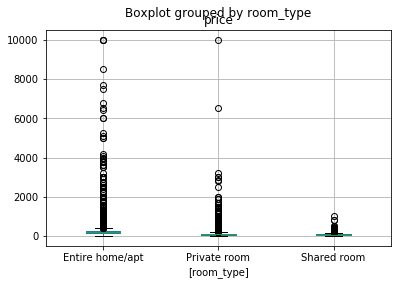

In [38]:
airbnb_m.boxplot(['price'],by=['room_type'])

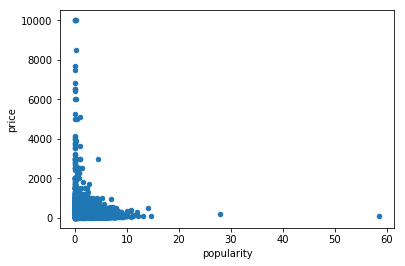

In [33]:
airbnb_m.plot(kind='scatter',x='popularity',y='price')

In [34]:
# cluster airbnb by prices and popularity
kclusters = 50
airbnb_pp = airbnb_m[['latitude','longtitude','price','popularity']]
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(airbnb_pp)
airbnb_m.insert(0, 'Cluster Labels', kmeans.labels_)
airbnb_m.head()

,Cluster Labels,name,host_name,borough,neighbourhood,latitude,longtitude,room_type,price,popularity
0,30,Skylit Midtown Castle,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,0.38
1,15,THE VILLAGE OF HARLEM....NEW YORK !,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,0.00
2,43,Entire Apt: Spacious Studio/Loft by central park,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,0.10
3,7,Large Cozy 1 BR Apartment In Midtown East,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,0.59
4,43,Large Furnished Room Near B'way,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,3.47


In [35]:
airbnb_mmean=airbnb_m.groupby(['Cluster Labels']).mean()
airbnb_mmean.sort_values(by=['popularity'],axis=0,ascending=False,inplace=True)
airbnb_mmean

,latitude,longtitude,price,popularity
Cluster Labels,,,,
20,40.772522,-73.969050,89.611374,1.188917
43,40.782553,-73.963691,74.939064,1.116600
8,40.746260,-73.987789,495.934307,1.115730
0,40.768374,-73.971872,102.646635,1.108096
44,40.748676,-73.985899,323.434211,1.097544
24,40.752673,-73.983332,595.833333,1.063981
38,40.752368,-73.986683,543.569444,1.062917
31,40.749324,-73.985375,441.864629,1.041048
26,40.800344,-73.955922,57.540823,1.033554


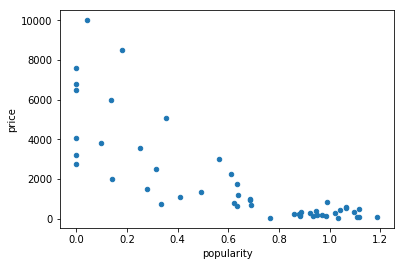

In [36]:
airbnb_mmean.plot(kind='scatter',x='popularity',y='price')

In [37]:
for lat, lon,pri,pop in zip(airbnb_mmean['latitude'],airbnb_mmean['longtitude'],airbnb_mmean['price'],airbnb_mmean['popularity']):
    label = folium.Popup('Popularity:{0:.2f}, meanprice: {1:.2f}'.format(pop,pri), parse_html=True)
    folium.Marker(
        [lat, lon],
        popup=label
        ).add_to(map_manhattan1)
map_manhattan1

### Discussion

In four categories(restaurants, arts, shopping and outdoors) in Manhattan, arts has the the least number of items, which is 835. Other three categories all has over 1000 items. 

All four categories are clustered into 100 clusters and shown in the map separately. Red markers show restaurant clusters; yellow markers show shopping places; blue markers how arts places; green markers show locations for outdoors. From the distribution of these clusters in the map, those four colors mix up evenly, which means there is no place that only one or two categories take adavantages. The more we reach the south of Manhattan, more attractions(include all four categories) show up. Most attractions accumulated on the south of the Broadway-Lafayette Street. And east side of the Manhattan has more attractions than the west side.

There are more than 21000 airbnb in Manhattan, and the price ranges from 0 to 10000. The price is related to the room type. Entire room/apt has the highest mean price compared with private room or shared room. More outliers which prices are higher than the maximum (third quarter + 1.5* interquartiel range) show in the type of entire room/apt, and followed by private room, and shared room. We assume the reviews per month is related to the popularity of the host. The one with higher reviews per month is more popular. No obvious trend is found in the relationship between the price and popularites if we consider the whole dataset. 

Then we divided airbnb based on their locations, prices and popularities and sorted the data by descending popularites. From the clustered data, generally cheaper airbnb has higher popularities. This is not always the truth because the popularity of the location is also decided by other reasons such as the hosts' attitudes, the cleaness of the room, etc. The price of the airbnb is generally higher on the south of Manhattan. The two clusters on the north of the Manhattan have relatively low price, which are 39 and 54 dollars per night. Travelers with low budget can consider this area. The mean price of the clusters on the south of the Manhattan is much higher than the mean price of the airbnb. This might be because they are close to many attractions. However, because of the high price, they do not have a high popularity. The majorities of the airbnb apartments are between 23rd and 50th street. The price and popularity are very diverse in this area. As there are many attractions in this area, and the mean prices in this area are generally acceptable. This area is recommended for most travelers in NYC.

### Conclusion

Based on the analysis and discussion above, main ideas are concluded here:

(1) There is no differences among the distribution of restaurants, arts, shopping and outdoors location. Travelers can always enjoy them in the same area.

(2) More attractions lay on the south part of Manhattan, and east side has more attractions than west side of Manhattan.

(3) Airbnb price is related to the room type. Usually private house/apt has higher price than private room or shared room. Generally cheaper airbnb will attract more travelers. 

(4) The price of the airbnb is higher on the south of Manhattan and lower on the north tof Manhattan, similar trend as the attractions number.

(5) For most travelers, the area between 23rd and 50th street is most recommended for them to choose airbnb. The price is very diverse in this area and there are many attractions in the area.